In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Plotting library
from scipy.optimize import minimize # Optimization module in scipy
import seaborn as sns
%matplotlib inline
from scipy.io import loadmat # will be used to load MATLAB mat datafile format

In [176]:
data = loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [177]:
#data

In [178]:
X_train, y_train = data['X'], data['y']
X_test, y_test = data['Xtest'], data['ytest']
X_val, y_val = data['Xval'], data['yval']

In [179]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

In [180]:
X_train

array([[-15.93675813],
       [-29.15297922],
       [ 36.18954863],
       [ 37.49218733],
       [-48.05882945],
       [ -8.94145794],
       [ 15.30779289],
       [-34.70626581],
       [  1.38915437],
       [-44.38375985],
       [  7.01350208],
       [ 22.76274892]])

Text(0, 0.5, 'Water flowing out of the dam (y)')

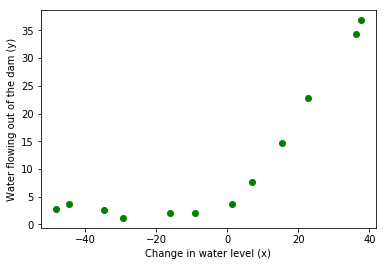

In [181]:
#Plot training example
plt.plot(X_train, y_train, 'go')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

### Regularized linear regression cost function

In [182]:
def linearRegCostFunction(theta, X, y, lambda_):
    
    m = len(y)
    h = np.dot(X, theta.T)
    grad = np.zeros(X.shape[1])
    error = h - y.ravel() # y is a 2D array, use ravel to make it 1D
    J = ((1/ (2*m)) * np.sum(error ** 2)) + ((lambda_/(2*m)) * np.sum(theta[1:] ** 2))
    grad[0] = (1/m) * np.dot(X[:,0], error)  
    grad[1:]= ((1/m) * np.dot(X[:,1], error)) + ((lambda_/m) * theta[1:])
    
    return J, grad

In [183]:
#def lrGradentReg(X, y, theta, lambda_):
    
    #m = len(y)
    #h = np.dot(X, theta)
    #error = h - y.ravel()
    #grad1 = (1/m) * np.dot(X[:,0], error)  
    #grad2= ((1/m) * np.dot(X[:,1], error)) + ((lambda_/m) * theta[1])
    
    #return np.array([grad1, grad2])


In [184]:
# Add intercept term to X_train 

X_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
initial_theta = np.array([1,1])
J, grad = linearRegCostFunction(X=X_train, y=y_train, theta=initial_theta, lambda_=1)
#gradient = lrGradentReg(X=X_train, y=y_train, theta=theta, lambda_=1 )

In [185]:
J, gradient

(303.9931922202643, array([-15.30301567, 598.25074417]))

In [186]:
def trainLinearReg(X, y, lambda_):
    initial_theta = np.array([0,0])
    res = minimize(linearRegCostFunction, initial_theta, args=(X, y, lambda_), method=None, jac=True,\
                     options={'maxiter':5000})
    
    return res

In [187]:
fit = trainLinearReg(X=X_train, y=y_train, lambda_=0)

In [188]:
fit.x

array([13.08790351,  0.36777923])

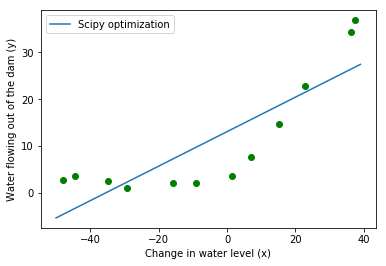

In [189]:
# Fitting optimized parameters to training example

x = np.arange(-50,40)
h = fit.x[0] + (fit.x[1] * x) # Linear regression hypothesis based on optimized parameters

plt.plot(x, h, label= 'Scipy optimization')

#Plot training example
plt.plot(X_train[:, 1], y_train, 'go')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.legend(loc='best')

In [190]:
# Define learning curve to debug the learning algorithm

# To achieve this add intercept one to Xval

X_val = np.concatenate((np.ones((len(X_val), 1)), X_val), axis=1)

def learningCurve(X_train, y_train, X_val, y_val, lambda_):
    
    m = len(X_train)
    
    error_train = np.zeros(m)
    error_val   = np.zeros(m)
    
    for i in range(len(X_train)):
        res = trainLinearReg(X_train[:i+1, :], y_train[:i+1], lambda_)
        error_train[i] = linearRegCostFunction(res.x, X_train[:i+1, :], y_train[:i+1], lambda_)[0]
        error_val[i] = linearRegCostFunction(res.x, X_val, y_val, lambda_)[0]
        
    return error_train, error_val    

In [191]:
error_train, error_val = learningCurve(X_train, y_train, X_val, y_val, lambda_=0)

In [192]:
error_train.shape, error_val.shape

((12,), (12,))

Text(0.5, 1.0, 'Learning curve for linear regression')

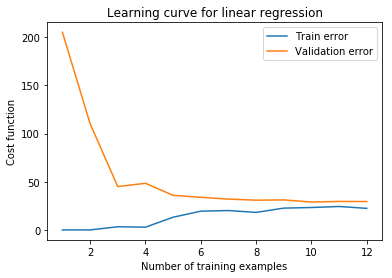

In [193]:
# Plot learning curve

plt.plot(np.arange(1, 13), error_train, label= 'Train error')
plt.plot(np.arange(1, 13), error_val, label = 'Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Cost function')
plt.legend(loc='best')
plt.title('Learning curve for linear regression')

#### . It is observed from the learning curve that a small gap exists between the train and validation error , Hence this results in underfitting   (a bias problem). therefore,  to debug the learning algorithm, we try adding more additional features.

## Polynomial regression

In [194]:
# Return X_train and X_val to original values

X_train, y_train = data['X'], data['y']
X_test, y_test = data['Xtest'], data['ytest']
X_val, y_val = data['Xval'], data['yval']

In [195]:
X_train.shape, X_val.shape, X_test.shape

((12, 1), (21, 1), (21, 1))

In [196]:
# To debug the learning algorithm, we define a function to make plynomial features with power p

def polyFeatures(X, p):
    
    X_poly = np.zeros((X.shape[0], p))
    
    for i in range(p):
        X_poly[:, i] = X.ravel() ** (i+1)
        
    return X_poly    

In [197]:
# Perform feature normalization to put features in same scale to make gradient descent algorithm reach optimum quickly

def featureNormalize(X):
    
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])
    
    for i in range(X.shape[1]):
        
        mu[i] = np.mean(X[:,i])
        sigma[i] = np.std(X[:,i])
        
        X_norm[:,i] = (X[:,i] - mu[i])/ sigma[i]
        
    
    
    return X_norm, mu, sigma

In [198]:
# Map X onto polynomial features and Normalize

p = 8

# Map X_poly_train, X_poly_val and X_poly_test onto polynomial features and Normalize and add bias unit 1

X_poly_train = polyFeatures(X_train, p)
X_poly_train = featureNormalize(X_poly_train)[0]
X_poly_train = np.concatenate((np.ones((len(X_poly_train), 1)), X_poly_train), axis=1)

X_poly_val = polyFeatures(X_val, p)
X_poly_val = featureNormalize(X_poly_val)[0]
X_poly_val = np.concatenate((np.ones((len(X_poly_val), 1)), X_poly_val), axis=1)

X_poly_test = polyFeatures(X_test, p)
X_poly_test = featureNormalize(X_poly_test)[0]
X_poly_test = np.concatenate((np.ones((len(X_poly_test), 1)), X_poly_test), axis=1)

In [199]:
X_poly_train.shape, X_poly_val.shape, X_poly_test.shape

((12, 9), (21, 9), (21, 9))

In [200]:
def trainPolyLinearReg(X, y, lambda_):
    initial_theta = np.zeros(X.shape[1])
    res = minimize(linearRegCostFunction, initial_theta, args=(X, y, lambda_), method=None, jac=True,\
                     options={'maxiter':55})
    
    return res

In [204]:
trainPolyLinearReg(X_poly_train, y_train, 0)

      fun: 26.162129171187445
 hess_inv: array([[ 1.0341277 , -0.0050014 , -0.0050014 , -0.0050014 , -0.0050014 ,
        -0.0050014 , -0.0050014 , -0.0050014 , -0.0050014 ],
       [-0.0050014 ,  0.95756323, -0.04243677, -0.04243677, -0.04243677,
        -0.04243677, -0.04243677, -0.04243677, -0.04243677],
       [-0.0050014 , -0.04243677,  0.95756323, -0.04243677, -0.04243677,
        -0.04243677, -0.04243677, -0.04243677, -0.04243677],
       [-0.0050014 , -0.04243677, -0.04243677,  0.95756323, -0.04243677,
        -0.04243677, -0.04243677, -0.04243677, -0.04243677],
       [-0.0050014 , -0.04243677, -0.04243677, -0.04243677,  0.95756323,
        -0.04243677, -0.04243677, -0.04243677, -0.04243677],
       [-0.0050014 , -0.04243677, -0.04243677, -0.04243677, -0.04243677,
         0.95756323, -0.04243677, -0.04243677, -0.04243677],
       [-0.0050014 , -0.04243677, -0.04243677, -0.04243677, -0.04243677,
        -0.04243677,  0.95756323, -0.04243677, -0.04243677],
       [-0.0050014 , 